Dependency links:
- [rdflib](https://github.com/RDFLib/rdflib)
- [imdbpie](https://github.com/richardasaurus/imdb-pie)
- [pandas](http://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://www.numpy.org/)
- [unidecode](https://pypi.python.org/pypi/Unidecode)

In [ ]:
# This step takes a while

import rdflib

g = rdflib.Graph()
g.parse("film_data.nt", format="nt")

len(g)

In [ ]:
import re

films = set()
tropes = set()
film_trope_dict = {}


for t_sub, t_obj in g.subject_objects(predicate=rdflib.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')):
    title = ''
    trope = ''
    try:
        title = re.match('http://dbtropes.org/resource/Film/([^/]*)', t_sub).groups()[0]
        trope = re.match('http://dbtropes.org/resource/Main/([^/]*)', t_obj).groups()[0]
        films.add(title)
        tropes.add(trope)
        if title in film_trope_dict:
            film_trope_dict[title].append(trope)
        else:
            film_trope_dict[title] = [trope]
    except Exception:
        pass


In [ ]:
print('# of films', len(films))
print('# of tropes', len(tropes))

In [ ]:
len(film_trope_dict)

In [1]:
# save / load film_trope_dict.pkl so that parsing with rdflib can be skipped if just playing with data visualization


import re # TODO: comment this line out if not starting from pickle 

import pickle

## write python dict to a file

# output = open('film_trope_dict.pkl', 'wb')
# pickle.dump(film_trope_dict, output)
# output.close()

# read python dict back from the file
pkl_file = open('film_trope_dict.pkl', 'rb')
film_trope_dict = pickle.load(pkl_file)
pkl_file.close()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Make a DataFrame of all film-trope pairs with an arbituary index
    
film_trope_df = pd.DataFrame.from_dict(film_trope_dict, orient ="index").sort_index().stack().reset_index(level=1, drop=True).reset_index()    
film_trope_df.columns = ['title', 'trope']
film_trope_df.head()

,title,trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder
1,ABeautifulMind,HollywoodNerd
2,ABeautifulMind,TheBigBoard
3,ABeautifulMind,MadMathematician
4,ABeautifulMind,EEqualsMCHammer


In [3]:
# Funtion to add spaces between words, in order to display tropes better

def add_space(text):
    return re.sub(r"\B([A-Z]+)", r" \1", text)

film_trope_df['trope'] = film_trope_df['trope'].map(add_space, na_action='ignore')

In [4]:
# Counting the frequency of each trope

total_counts = pd.DataFrame(film_trope_df['trope'].value_counts()).reset_index()
total_counts.columns = ['trope', 'counts']

In [32]:
# # Function to plot the distribution of the count frequency.
# # ax: where to plot
# # df: sorted DataFrame of frequencies, with an autoincrement index
# # col_data: name of the column that contains the counts
# # title, xlabel, ylabel: figure labels

# def plot_counts_dist(ax, df, col_data, title, xlabel='Trope Rank (within group)', ylabel='Trope Frequency (%)'):
#     counts_sum = df[col_data].sum()
    
    
#     ax.fill_between(x = df.index, y1 = df[col_data] / counts_sum * 100, y2 = 0, color = 'b', alpha = 0.5)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')

#     ax.set_xlim(0, len(df))
#     ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)


# fig, ax = plt.subplots()
# plot_counts_dist(ax, total_counts, 'counts', title = 'Distribution of Trope Frequencies \nAmong All Films in DBtropes')

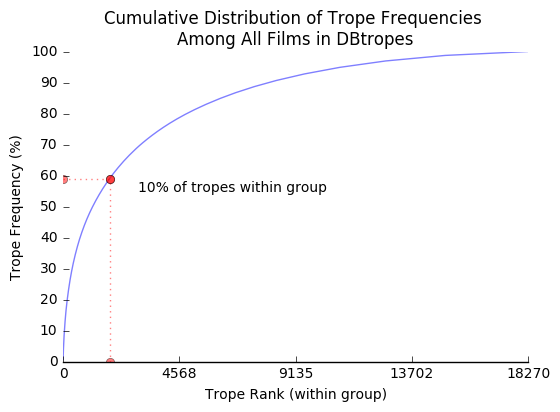

In [44]:
# Function to plot the cumulative distribution of the count frequency.
# ax: where to plot
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_data: name of the column that contains the counts
# title, xlabel, ylabel: figure labels

def plot_counts_cumsum(ax, df, col_data, title, xlabel='Trope Rank (within group)', ylabel='Trope Frequency (%)'):
    counts_sum = df[col_data].sum()
    cumsum_df = df[col_data].cumsum() / counts_sum * 100
    
    ax.plot(cumsum_df, color = 'b', alpha = 0.5)
    
    # add lines at 10% total trope population
    px = round(0.1 * len(cumsum_df))
    py = cumsum_df.loc[px]
    ax.plot([px, px], [0, py], 'r:', marker = 'o', alpha = 0.5)
    ax.plot([0, px], [py, py], 'r:', marker = 'o', alpha = 0.5)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlim(0, len(df))
    ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]) * len(df))
    ax.set_yticks(np.arange(0, 110, 10))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


fig, ax = plt.subplots()
plot_counts_cumsum(ax, total_counts, 'counts', title = 'Cumulative Distribution of Trope Frequencies \nAmong All Films in DBtropes')
fig.text(0.25, 0.55, 'top 10% of tropes within group')

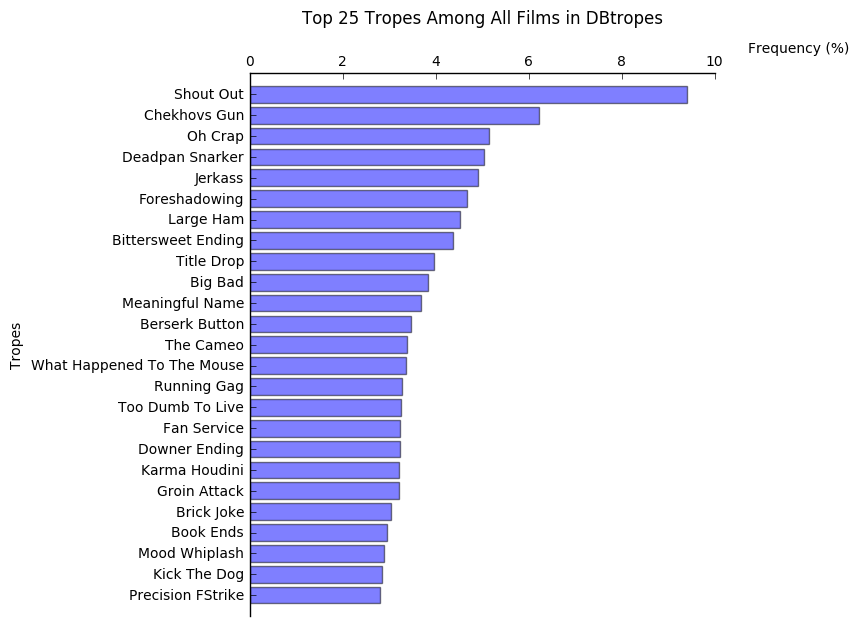

In [114]:
# Function to plot a 'histogram' of top frequencies
# ax: where to plot the figure
# df: sorted DataFrame of frequencies, with an autoincrement index
# col_label: name of the column that contains the trope labels 
# col_data: name of the column that contains the counts
# denominator: number of tropes of the whole sample, for standardization
# n: number of tropes to be shown, default 25
# title, xlabel, ylabel: figure labels
# color, alpha: bar appearance, default color = blue, alpha = 0.5
# flip_x: flip x axis, default False

def plot_counts(ax, df, col_label, col_data, denominator, title, xlabel='Frequency (%)', ylabel='Tropes', 
                color='blue', alpha=0.5, n=25, flip_x=False):
    new = df.head(n)
    counts_sum = new[col_data].sum()
        
    ax.barh(new.index, new[col_data] / counts_sum * 100, color=color, alpha=alpha, align='center')
    ax.set_yticks(np.arange(len(new[col_label])))
    ax.set_yticklabels(new[col_label])
    ax.set_ylim(-1, len(new[col_label]))
    ax.invert_yaxis()

    if flip_x:
        ax.invert_xaxis()
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.xaxis.set_ticks_position('top')
    else:
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('top')
    
    ax.set_xlabel(xlabel)
    ax.xaxis.set_label_coords(1.18, 1.06)
    ax.set_ylabel(ylabel)
    ax.set_title(title, y = 1.08)

fig, ax = plt.subplots(figsize=(6, 7))
denominator = total_counts['counts'].sum()
plot_counts(ax, total_counts, 'trope', 'counts', denominator, title='Top 25 Tropes Among All Films in DBtropes')

In [35]:
from imdbpie import Imdb

# Initiate imdb
imdb = Imdb()
imdb = Imdb(anonymize=True) # to proxy requests

In [36]:
top_movies = imdb.top_250()
top_250 = pd.DataFrame([movie['title'] for movie in top_movies], columns = ['imdb_title'])             

In [37]:
# Function to strip spaces, capitalization, punctuation and accents from stitles.

import unidecode
def strip_lowercase(text):
    text = unidecode.unidecode(text) # dependency: unidecode
    return re.sub(r'[^\w]', '', text).lower()

film_trope_df['strip_title'] = film_trope_df['title'].map(strip_lowercase, na_action='ignore')
top_250['strip_title'] = top_250['imdb_title'].map(strip_lowercase, na_action='ignore')

top_250['isin_dbtrope'] = top_250['strip_title'].isin(film_trope_df['strip_title'])
film_trope_df['is_top250'] = film_trope_df['strip_title'].isin(top_250['strip_title'])

In [38]:
len(film_trope_df[film_trope_df['is_top250'] == True]['title'].unique())
# TODO: this means there are some unfortunate mis-naming happening. Need more cleaning.
# Also some films in the top 250 do not have any trope instances, eg. Nausicaä of the Valley of the Wind

165

In [39]:
# Counting tropes for movies that are in the top 250
top_counts = pd.DataFrame(film_trope_df[film_trope_df['is_top250'] == True]['trope'].value_counts()).reset_index()
top_counts.columns = ['trope', 'counts']

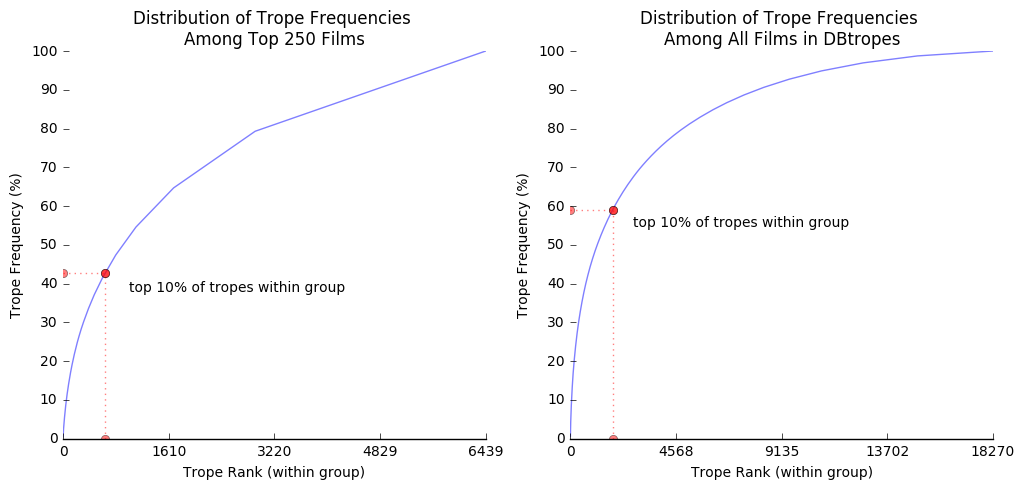

In [55]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5)) 
plt.setp(ax[1].get_yticklabels(), visible=True)
plot_counts_cumsum(ax[0], top_counts, 'counts', title='Distribution of Trope Frequencies \nAmong Top 250 Films') 
plot_counts_cumsum(ax[1], total_counts, 'counts', title='Distribution of Trope Frequencies \nAmong All Films in DBtropes')    

fig.text(0.18, 0.42, 'top 10% of tropes within group')
fig.text(0.6, 0.55, 'top 10% of tropes within group')
#plt.savefig('cum_distribution.png')

In [118]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharex=True) 
# plt.setp(ax[1].get_yticklabels(), visible=True)

# n = 25 # showing top n counts
# total_counts_n = total_counts.head(n)
# top_counts_n = top_counts.head(n)


# # Mark shared tropes with a different color
# left_common = top_counts_n['trope'].isin(total_counts.head(n)['trope']).values
# right_common = total_counts_n['trope'].isin(top_counts.head(n)['trope']).values

# # Function to translate [True, False,...] to [color1, color2, ...]        
# def color_mask(boolin_array, color1, color2):
#     output = []
#     for b in boolin_array:
#         if b:
#             output.append(color1)
#         else:
#             output.append(color2)
#     return output
        
# left_colors = color_mask(left_common, 'lightgrey', 'lightsalmon')
# right_colors = color_mask(right_common, 'lightgrey', 'lightgreen')
    
# left_fig = plot_counts(ax[0], top_counts, 'trope', 'counts', denominator = top_counts['counts'].sum(), 
#                        xlabel='', ylabel='', color=left_colors,
#                        title='Top 250 Films', n=n)

# right_fig = plot_counts(ax[1], total_counts, 'trope', 'counts', denominator = total_counts['counts'].sum(), 
#                         ylabel='', color=right_colors,
#                         title ='All Films', n=n)


# my_suptitle = plt.suptitle('Top 25 Tropes \n(highlighting unique tropes)', y=1.08, fontsize=16)

# plt.subplots_adjust(wspace=0.5)

# #fig.savefig('top25_unique_tropes.png', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])


In [119]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharex=True) 
# plt.setp(ax[1].get_yticklabels(), visible=True)

# n = 25 # showing top n counts
# total_counts_n = total_counts.head(n)
# top_counts_n = top_counts.head(n)

# # Highlight m most popular tropes from top_250 films in both graphs
# m = 7
# popular_left = top_counts_n['trope'].isin(top_counts.head(m)['trope']).values
# popular_right = total_counts_n['trope'].isin(top_counts.head(m)['trope']).values

# popular_left_colors = color_mask(popular_left, 'red', 'lightgray')
# popular_right_colors = color_mask(popular_right, 'red', 'lightgray')

# left_fig = plot_counts(ax[0], top_counts, 'trope', 'counts', denominator = top_counts['counts'].sum(), xlabel='', 
#                        ylabel='', color = popular_left_colors,
#                        title='Top 250 Films', n=n)

# right_fig = plot_counts(ax[1], total_counts, 'trope', 'counts', denominator = total_counts['counts'].sum(), 
#                         ylabel='', color = popular_right_colors,
#                         title ='All Films', n=n)


# my_suptitle=plt.suptitle('Top 25 Tropes \n(highlighting the 7 most popular tropes in top films)', y=1.08, fontsize=16)

# plt.subplots_adjust(wspace = 0.5)

# #fig.savefig('most_popular_tropes_top_films.png', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

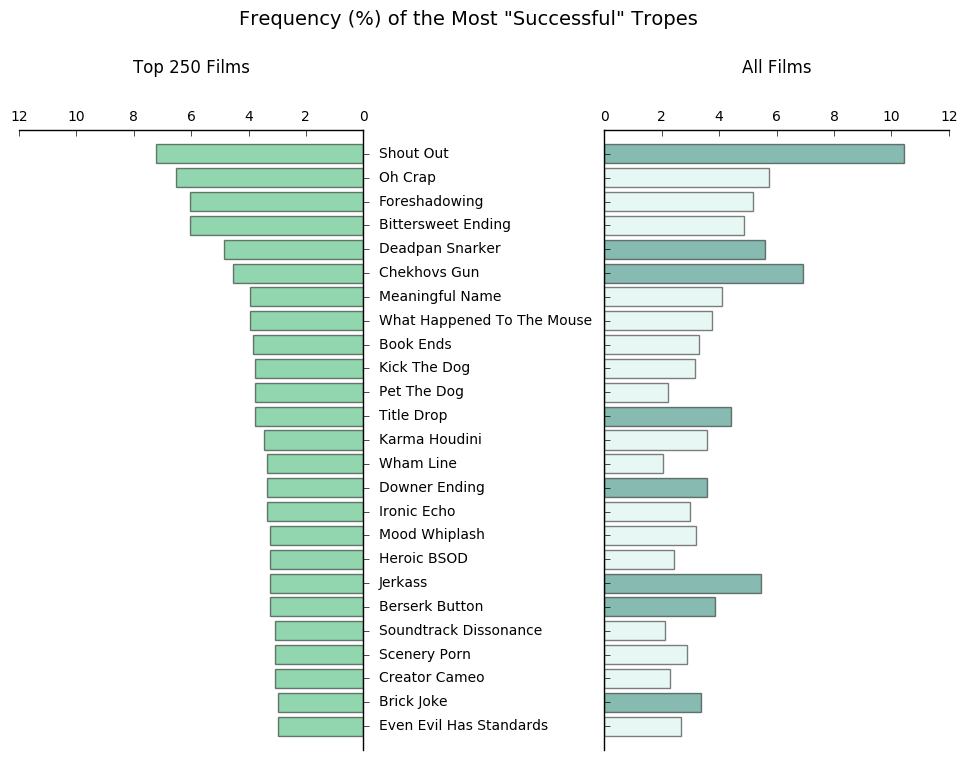

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8)) 
plt.setp(ax[1].get_yticklabels(), visible=True)

# Visualize the top n tropes from top movies (aka. the "successful" tropes) in two samples
n = 25 # showing top n counts
successful_tropes = top_counts.head(n)

successful_tropes_counts = successful_tropes.merge(total_counts, left_on='trope', right_on='trope', how='left')
successful_tropes_counts.columns = ['trope', 'top_250_counts', 'all_counts']

# Function to translate [True, False,...] to [color1, color2, ...]        
def color_mask(boolin_array, color1, color2):
    output = []
    for b in boolin_array:
        if b:
            output.append(color1)
        else:
            output.append(color2)
    return output

# Standardize counts
successful_tropes_counts['all_counts_s'] = successful_tropes_counts['all_counts'] / total_counts['counts'].sum()
successful_tropes_counts['top_250_counts_s'] = successful_tropes_counts['top_250_counts'] / top_counts['counts'].sum()
# Use color to label relative frequency differences
compare_color = color_mask(successful_tropes_counts['all_counts_s'] >= successful_tropes_counts['top_250_counts_s'],
                           '#117864', '#D1F2EB')

# butterfly graph

left_fig = plot_counts(ax[0], successful_tropes_counts, 'trope', 'top_250_counts', color='#27AE60',
                       denominator=top_counts['counts'].sum(), xlabel='', ylabel='',
                       title='Top 250 Films', n=n, flip_x=True)

right_fig = plot_counts(ax[1], successful_tropes_counts, 'trope', 'all_counts', color=compare_color,
                        denominator=total_counts['counts'].sum(), ylabel='',
                        title='All Films', n=n)

ax[0].tick_params(axis='y', direction='out', pad=7)
ax[0].set_xlim(12, 0)
ax[0].set_xlabel('')
ax[1].set_xlim(0, 12)
ax[1].set_xlabel('')
labels = [item.get_text() for item in ax[1].get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax[1].set_yticklabels(empty_string_labels)

my_suptitle=plt.suptitle('Frequency (%) of the Most "Successful" Tropes', y=1.05, fontsize=14)

plt.subplots_adjust(wspace = 0.7)

#fig.savefig('most_popular_tropes_top_films.png', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[my_suptitle])

In [ ]:
# TODO: Make a DataFrame of all movies in film_trope_dict: imdb id, title, year, genres